### Imports

Esta célula de código faz as importações necessária para o funcionamento do projeto

- **os**: Permite a manipulação de sistema de ficheiros e operações em pastas
- **shuntil**: Fornece várias operações, como copiar, mover, remover pastas
- **path**: Fornece classes para manipulação de *paths*
- **numpy**: Biblioteca para manipulação de arrays e operações matemáticas
- **image_dataset_from_directory**: Utilizado para carregar um conjunto de dados de imagens a partir de uma pasta
- **keras,layers, models**: Submódulos do Keras, utilizados para construir arquiteturas de modelos de redes neuronais
- **tensorflow**: Biblioteca de código *open-source*, para computação numérica e implementação de algoritmos de aprendizagem
- **VGG16**: Arquitetura de rede neural convolucional pré-treinada
- **EarlyStopping**: Callback para utilizar durante o treino dos modelos para interromper o processo caso não exista melhorias métricas
- **ModelCheckpoint**: Callback para utilizar durante o treino dos modelos para guardar o processo caso não exista melhorias métricas
- **matplotlib**: Biblioteca para criar gráficos e visualizações que ajudam na análise dos resultados do treino dos modelos

In [1]:
#imports
import os, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-06-22 19:19:08.920828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 19:19:10.659380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reunir as imagens
**Atenção**: esta célula de código só é necessaria correr uma vez, apesar de estar em todos os *notebooks*

Nesta célula de código, fazemos a junção de todas as imagens das pastas de treino (*train1*, *train3*, *train4*, *train5*) numa só pasta, chamada de "temp_train", que vai conter todo o conteudo das pastas de treino, assim tendo um dataset único com bastantes imagens.


In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    temp_train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical')

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical')


### Carregar as imagens

Esta célula de código define váriaveis aos caminhos das diretorias

Após ser "corrido" a célula de código acima, é possivel carregar a nova pasta chamada de temp_train juntamente com as pastas de validação, e de testes.


In [2]:
temp_train_dir = 'temp_train'
validation_dir = 'train2'
test_dir = 'test'

### Carregar a arquitetura VGG16

Esta célula de código carrega a arquitetura da rede neural convolucional VGG16 pré-treinada e congela os seus pesos.

In [4]:

conv_base = VGG16(weights='imagenet', include_top=False)
conv_base.trainable = False

### Construir o modelo

Neste código definimos:

- A entrada do modelo com a altura 150, a largura 150, e o RGB com 3 (os três canais de cor).
- Utilizamos a função keras.applications.vgg16.preprocess_input para pré-processar os inputs de acordo com os requisitos do VGG16.
- Passamos os inputs pré-processados pela base convolucional do VGG16, que extrai características das imagens.
- De seguida com o **layers.Flatten()(x)** transformamos os dados de saida das camadas convulacionais num vetor unidimensional.
- Com o **layers.Dense(512, activation="relu")(x)** adicionamos uma camada com 512 unidades e a função **relu**, isto permite que a rede aprenda combinações mais complexas das caracteristicas extraidas.
- Depois com o **layers.Dense(10,activation="softmax")(x)** definimos a camada de saida, com 10 unidades (número de sub-pastas em cada pasta de treino), e ainda utilizamos a ativação **softmax** que normalmente usada para problemas de classificação.
- Por fim, criamos o novo modelo com o **keras.Model(inputs=inputs, outputs=outputs)**, onde os *inputs* são as camadas de entrada e os *outputs* são as camadas de saida anteriormente definidas

In [5]:
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

### Summary do modelo

De seguida fazemos o summary do mesmo para visualizar a sua arquitetura

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 150, 150)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 150, 150)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 150, 150)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 150, 150,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 150, 150,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,097,408 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      2,570 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,814,666 (64.14 MB)

 Trainable params: 2,099,978 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)        </span>┃<span style="font-weight: bold"> Output Shape      </span>┃<span style="font-weight: bold">    Param # </span>┃<span style="font-weight: bold"> Connected to      </span>┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ -                 │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)        │ <span style="color: #00af00; text-decoration-color: #00af00">3</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (<span style="color: #0087ff; text-decoration-color: #0087ff">GetItem</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>)  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ input_layer_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>)  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ input_layer_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">GetItem</span>)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>)  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ input_layer_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>]… │
│ (<span style="color: #0087ff; text-decoration-color: #0087ff">GetItem</span>)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (<span style="color: #0087ff; text-decoration-color: #0087ff">Stack</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ get_item[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>],   │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">3</span>)                │            │ get_item_1[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>], │
│                     │                   │            │ get_item_2[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (<span style="color: #0087ff; text-decoration-color: #0087ff">Add</span>)           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>, <span style="color: #00af00; text-decoration-color: #00af00">150</span>,  │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ stack[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]       │
│                     │ <span style="color: #00af00; text-decoration-color: #00af00">3</span>)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (<span style="color: #0087ff; text-decoration-color: #0087ff">Functional</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>) │ <span style="color: #00af00; text-decoration-color: #00af00">14,714,688</span> │ add[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">8192</span>)      │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ vgg16[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)       │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">256</span>)       │  <span style="color: #00af00; text-decoration-color: #00af00">2,097,408</span> │ flatten[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">256</span>)       │          <span style="color: #00af00; text-decoration-color: #00af00">0</span> │ dense[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)     │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>)        │      <span style="color: #00af00; text-decoration-color: #00af00">2,570</span> │ dropout[<span style="color: #00af00; text-decoration-color: #00af00">0</span>][<span style="color: #00af00; text-decoration-color: #00af00">0</span>]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Total params: </span><span style="color: #00af00; text-decoration-color: #00af00">16,814,666</span> (64.14 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">2,099,978</span> (8.01 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">14,714,688</span> (56.13 MB)
</pre>


### Compilar e treinar o modelo

Nesta célula de código, configuramos o processo de compilação do modelo construido anteriormente.

- **loss='categorical_crossentropy'** utilizamos a função de perda 'categorical_crossentropy', pois é uma função utilizada normalmente em problemas de classificação
- **optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)** aqui escolhemos o otimizador RMSprop, com uma taxa de *learning* de 0.0001
-  **metrics=['accuracy']** por fim, definimos a métrica para avaliar o desempenho do modelo durante o treino para ser a *accuracy* 

Nesta célula de código implementamos:
- Definimos o model_checkpoint para este guardar **apenas** os melhores resultados, conforme o valor da 'val_loss'. Este guarda o melhor resultado dentro da pasta 'models' com o nome adequado.

- Iniciamos o treino do modelo com o conjunto de dados de treinamento, definido ainda o número de epochs como 30, e avaliando o mesmo com o conjunto de dados de validaçao.

Por fim a avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='models/Projeto_T_sem_data_augmentation_antes_fine_tuning_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[model_checkpoint])

val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy before fine-tuning:', val_acc)

Epoch 1/30


I0000 00:00:1719069237.635079    3176 service.cc:145] XLA service 0x7f6c1800c400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719069237.635234    3176 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-22 16:13:57.704587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 16:13:57.954883: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-22 16:14:00.242624: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   3/1250 ━━━━━━━━━━━━━━━━━━━━ 1:17 62ms/step - accuracy: 0.0972 - loss: 42.1582

I0000 00:00:1719069248.645712    3176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 82ms/step - accuracy: 0.7359 - loss: 14.8188 - val_accuracy: 0.8543 - val_loss: 4.3581
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.8361 - loss: 4.4896 - val_accuracy: 0.8404 - val_loss: 3.3146
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.8571 - loss: 2.8388 - val_accuracy: 0.8561 - val_loss: 3.4384
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.8706 - loss: 2.6601 - val_accuracy: 0.8438 - val_loss: 4.3466
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.8826 - loss: 2.5034 - val_accuracy: 0.8351 - val_loss: 5.3706
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.8942 - loss: 2.3934 - val_accuracy: 0.8349 - val_loss: 5.7184
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9017 - loss: 2.3023 - val_accuracy: 0.8629 - val_loss: 5.5203
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9075 - loss: 2.

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 115s 82ms/step - accuracy: 0.7359 - loss: 14.8188 - val_accuracy: 0.8543 - val_loss: 4.3581

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.8361 - loss: 4.4896 - val_accuracy: 0.8404 - val_loss: 3.3146

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.8571 - loss: 2.8388 - val_accuracy: 0.8561 - val_loss: 3.4384

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.8706 - loss: 2.6601 - val_accuracy: 0.8438 - val_loss: 4.3466

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.8826 - loss: 2.5034 - val_accuracy: 0.8351 - val_loss: 5.3706

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.8942 - loss: 2.3934 - val_accuracy: 0.8349 - val_loss: 5.7184

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9017 - loss: 2.3023 - val_accuracy: 0.8629 - val_loss: 5.5203

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9075 - loss: 2.4495 - val_accuracy: 0.8609 - val_loss: 5.9768

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.9151 - loss: 2.3019 - val_accuracy: 0.8636 - val_loss: 6.3737

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.9191 - loss: 2.2869 - val_accuracy: 0.8594 - val_loss: 6.9942

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9242 - loss: 2.2622 - val_accuracy: 0.8624 - val_loss: 7.5051

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9256 - loss: 2.3231 - val_accuracy: 0.8528 - val_loss: 8.4791

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9280 - loss: 2.2695 - val_accuracy: 0.8625 - val_loss: 8.3440

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9303 - loss: 2.3195 - val_accuracy: 0.8657 - val_loss: 9.0800

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.9345 - loss: 2.3982 - val_accuracy: 0.8617 - val_loss: 9.8335

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.9377 - loss: 2.2480 - val_accuracy: 0.8636 - val_loss: 10.4079

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.9409 - loss: 2.2137 - val_accuracy: 0.8582 - val_loss: 11.7924

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 76ms/step - accuracy: 0.9429 - loss: 2.2797 - val_accuracy: 0.8645 - val_loss: 11.8867

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.9438 - loss: 2.2947 - val_accuracy: 0.8592 - val_loss: 12.8096

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.9459 - loss: 2.3472 - val_accuracy: 0.8641 - val_loss: 13.2373

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.9475 - loss: 2.2514 - val_accuracy: 0.8621 - val_loss: 13.5143

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 81ms/step - accuracy: 0.9501 - loss: 2.2191 - val_accuracy: 0.8618 - val_loss: 14.4496

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 78ms/step - accuracy: 0.9506 - loss: 2.2663 - val_accuracy: 0.8645 - val_loss: 14.7847

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 79ms/step - accuracy: 0.9536 - loss: 2.1179 - val_accuracy: 0.8605 - val_loss: 15.3684

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.9539 - loss: 2.0943 - val_accuracy: 0.8653 - val_loss: 15.7998

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.9547 - loss: 2.0937 - val_accuracy: 0.8611 - val_loss: 16.6512

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.9581 - loss: 2.1090 - val_accuracy: 0.8607 - val_loss: 17.4781

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.9573 - loss: 2.0087 - val_accuracy: 0.8645 - val_loss: 17.7906

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 76ms/step - accuracy: 0.9570 - loss: 2.1154 - val_accuracy: 0.8630 - val_loss: 18.3361

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.9588 - loss: 2.1342 - val_accuracy: 0.8591 - val_loss: 19.5405

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8595 - loss: 20.2593
Validation accuracy before fine-tuning: 0.8590999841690063

### Guardar o modelo criado

Guardamos o módelo com um nome apropriado, dentro da pasta 'models'

In [7]:
model.save('models/Projeto_T_sem_data_augmentation_antes_fine_tuning.keras')

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, neste caso são os graficos antes do fine-tuning.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*, possibilitando ver o desempenho e o *overfitting*.

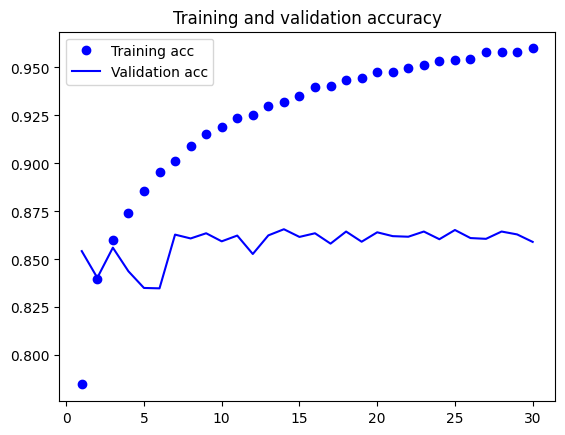

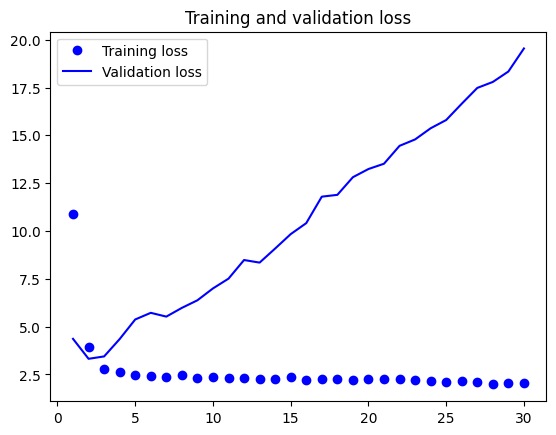

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Ajustar a base convucional VGG16

Nesta célula de código começamos por obter a layer VGG16

De seguinda congelamos as primeiras camadas da base convolucional para preservar os pesos pré-treinados, deixando apenas as últimas quatro camadas treináveis

Ainda fazemos um print para poder observar os resultados

In [9]:
convbase = model.get_layer("vgg16")
convbase.trainable = True

for layer in convbase.layers[:-4]:
    layer.trainable = False

for i, layer in enumerate(convbase.layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


0 input_layer False

1 block1_conv1 False

2 block1_conv2 False

3 block1_pool False

4 block2_conv1 False

5 block2_conv2 False

6 block2_pool False

7 block3_conv1 False

8 block3_conv2 False

9 block3_conv3 False

10 block3_pool False

11 block4_conv1 False

12 block4_conv2 False

13 block4_conv3 False

14 block4_pool False

15 block5_conv1 True

16 block5_conv2 True


17 block5_conv3 True


18 block5_pool True


### Compilar e treinar o modelo APOS o fine-tuning

Nesta célula de código voltamos a fazer o treino, mas desta vez, com o fine-tuning aplicado, para gerar resultados melhores

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath='models/Projeto_T_sem_data_augmentation_depois_fine_tuning_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,
    restore_best_weights=True 
)

callbacks = [model_checkpoint]

historyAfter = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 94ms/step - accuracy: 0.2387 - loss: 6.2276 - val_accuracy: 0.2187 - val_loss: 2.0016
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.2583 - loss: 1.9847 - val_accuracy: 0.4284 - val_loss: 1.6074
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 99ms/step - accuracy: 0.4468 - loss: 1.5905 - val_accuracy: 0.5674 - val_loss: 1.2859
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.5777 - loss: 1.2665 - val_accuracy: 0.6233 - val_loss: 1.3190
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.6171 - loss: 1.1868 - val_accuracy: 0.6014 - val_loss: 1.2616
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.6612 - loss: 1.0178 - val_accuracy: 0.6767 - val_loss: 1.1209
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.7110 - loss: 0.9557 - val_accuracy: 0.6879 - val_loss: 1.3319
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accur

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 94ms/step - accuracy: 0.2387 - loss: 6.2276 - val_accuracy: 0.2187 - val_loss: 2.0016

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.2583 - loss: 1.9847 - val_accuracy: 0.4284 - val_loss: 1.6074

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 99ms/step - accuracy: 0.4468 - loss: 1.5905 - val_accuracy: 0.5674 - val_loss: 1.2859

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.5777 - loss: 1.2665 - val_accuracy: 0.6233 - val_loss: 1.3190

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.6171 - loss: 1.1868 - val_accuracy: 0.6014 - val_loss: 1.2616

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.6612 - loss: 1.0178 - val_accuracy: 0.6767 - val_loss: 1.1209

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.7110 - loss: 0.9557 - val_accuracy: 0.6879 - val_loss: 1.3319

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.7540 - loss: 0.8476 - val_accuracy: 0.6946 - val_loss: 1.2497

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.7697 - loss: 0.7660 - val_accuracy: 0.7171 - val_loss: 1.1373

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 100ms/step - accuracy: 0.7895 - loss: 0.7227 - val_accuracy: 0.7015 - val_loss: 1.2383

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8073 - loss: 0.7072 - val_accuracy: 0.7317 - val_loss: 1.1274

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8150 - loss: 0.6484 - val_accuracy: 0.7485 - val_loss: 1.2979

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 99ms/step - accuracy: 0.8281 - loss: 0.6774 - val_accuracy: 0.7371 - val_loss: 1.4741

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8327 - loss: 0.6136 - val_accuracy: 0.7444 - val_loss: 1.1570

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 101ms/step - accuracy: 0.8410 - loss: 0.5473 - val_accuracy: 0.7707 - val_loss: 1.3565

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8507 - loss: 0.5459 - val_accuracy: 0.7624 - val_loss: 1.7125

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 98ms/step - accuracy: 0.8565 - loss: 0.5495 - val_accuracy: 0.7594 - val_loss: 1.7696

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8630 - loss: 0.5266 - val_accuracy: 0.7376 - val_loss: 2.2801

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8603 - loss: 0.5089 - val_accuracy: 0.7317 - val_loss: 1.9721

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 97ms/step - accuracy: 0.8679 - loss: 0.5056 - val_accuracy: 0.7720 - val_loss: 1.9194

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8742 - loss: 0.4781 - val_accuracy: 0.7723 - val_loss: 1.9891

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.8732 - loss: 0.5084 - val_accuracy: 0.7513 - val_loss: 1.8799

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 96ms/step - accuracy: 0.8746 - loss: 0.5104 - val_accuracy: 0.7484 - val_loss: 1.5159

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.8758 - loss: 0.4852 - val_accuracy: 0.7756 - val_loss: 1.5632

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.8883 - loss: 0.4854 - val_accuracy: 0.7368 - val_loss: 1.9750

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.8823 - loss: 0.5596 - val_accuracy: 0.7722 - val_loss: 1.7883

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 120s 96ms/step - accuracy: 0.8880 - loss: 0.4905 - val_accuracy: 0.7768 - val_loss: 2.1750

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 98ms/step - accuracy: 0.8908 - loss: 0.4875 - val_accuracy: 0.7739 - val_loss: 1.9075

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8906 - loss: 0.4771 - val_accuracy: 0.7682 - val_loss: 1.7253

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 99ms/step - accuracy: 0.8878 - loss: 0.5369 - val_accuracy: 0.7340 - val_loss: 2.3214

### Avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [11]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('Validation accuracy after fine-tuning:', val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7304 - loss: 2.4316
Validation accuracy after fine-tuning: 0.734000027179718


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7304 - loss: 2.4316

Validation accuracy after fine-tuning: 0.734000027179718

### Guardar o modelo criado

Guardamos o módelo com um nome apropriado, dentro da pasta 'models'

In [12]:
model.save('models/Projeto_T_sem_data_augmentation_depois_fine_tuning.keras')

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, neste caso são os graficos depois do fine-tuning.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*, possibilitando ver o desempenho e o *overfitting*.

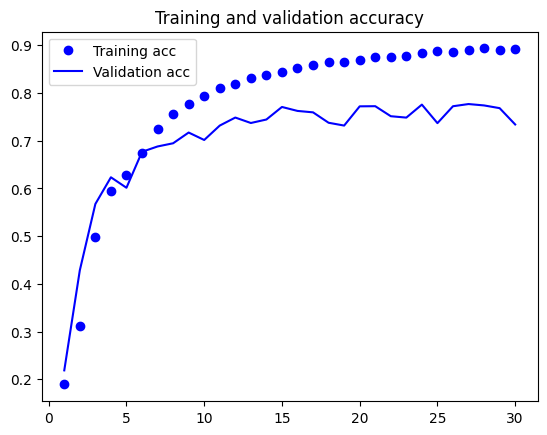

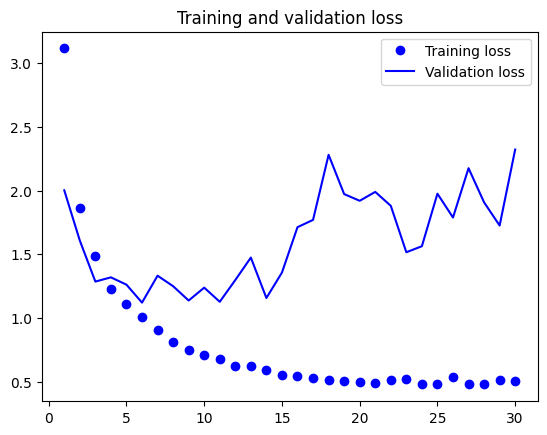

In [13]:
acc = historyAfter.history['accuracy']
val_acc = historyAfter.history['val_accuracy']
loss = historyAfter.history['loss']
val_loss = historyAfter.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Relatório

#### Objetivo

Neste *notebook* desenvolvemos uma rede convolucional com Transfer Learning e técnicas de Transfer Learning numa tentativa de melhorar as precisões:

- **Camada de entrada:** Recebe imagens de dimensão 150x150 pixels e 3 canais de cor (RGB).
- **Camada de pré-processamento:** Realiza operações de obtenção de itens e empilhamento.
- **Camada VGG16:** Convolucional pré-treinada com saída de dimensão 4x4x512.
- **Camada flatten:** Transforma a saída da VGG16 em uma única dimensão (8192).
- **Camada fully connected (Dense):** 256 unidades, seguida de uma camada de dropout com taxa de 50%.
- **Camada de saída (Dense):** 10 unidades para classificação, usando softmax como função de ativação.

#### Desenvolvimento

Desenvolvemos a seguinte rede:

| Layer (type)       | Output Shape     |    Param # | Connected to      |
|--------------------|------------------|------------|-------------------|
| input_layer_1      | (None, 150, 150, |          0 | -                 |
| (InputLayer)       | 3)               |            |                   |
| get_item (GetItem) | (None, 150, 150) |          0 | input_layer_1[0][0] |
| get_item_1         | (None, 150, 150) |          0 | input_layer_1[0][0] |
| (GetItem)          |                  |            |                   |
| get_item_2         | (None, 150, 150) |          0 | input_layer_1[0][0] |
| (GetItem)          |                  |            |                   |
| stack (Stack)      | (None, 150, 150, |          0 | get_item[0][0],   |
|                    | 3)               |            | get_item_1[0][0], |
|                    |                  |            | get_item_2[0][0]  |
| add (Add)          | (None, 150, 150, |          0 | stack[0][0]       |
|                    | 3)               |            |                   |
| vgg16 (Functional) | (None, 4, 4, 512)| 14,714,688 | add[0][0]         |
| flatten (Flatten)  | (None, 8192)     |          0 | vgg16[0][0]       |
| dense (Dense)      | (None, 256)      |  2,097,408 | flatten[0][0]     |
| dropout (Dropout)  | (None, 256)      |          0 | dense[0][0]       |
| dense_1 (Dense)    | (None, 10)       |      2,570 | dropout[0][0]     |


Neste modelo foi aplicado o conceito de ***transfer learning***, isto é, a utilização de um modelo pré-treinado e adaptado para o nosso problema de classificação.

Para além disso, usamos também o ***fine tuning*** que é uma técnica utilizada no *transfer learning* para "afinar" o modelo congelando as camadas convolucionais do modelo pré-treinado. Com isto obtemos os seguintes resultados:

- **antes do fine tuning:**

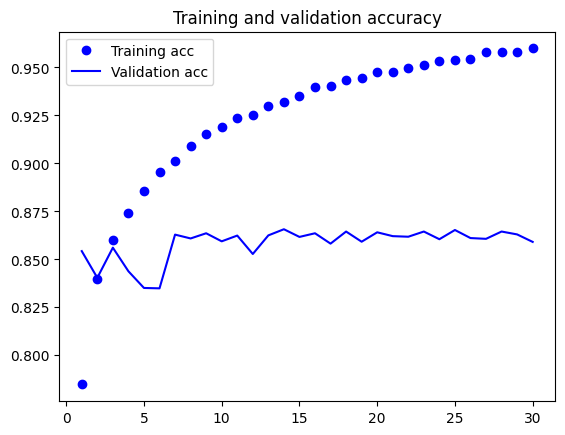

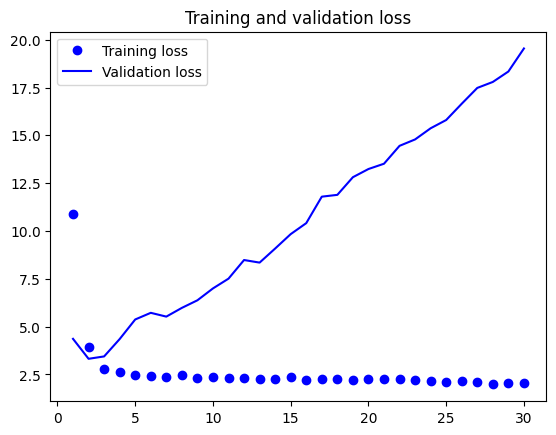

**val_acc:** 0.8590999841690063

- **depois do fine tuning, deixando apenas 4 camadas treinaveis:**

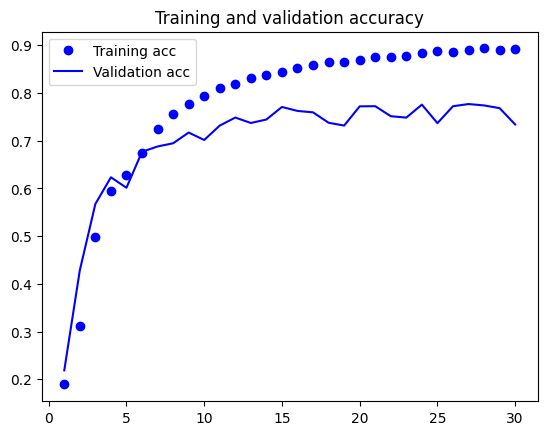

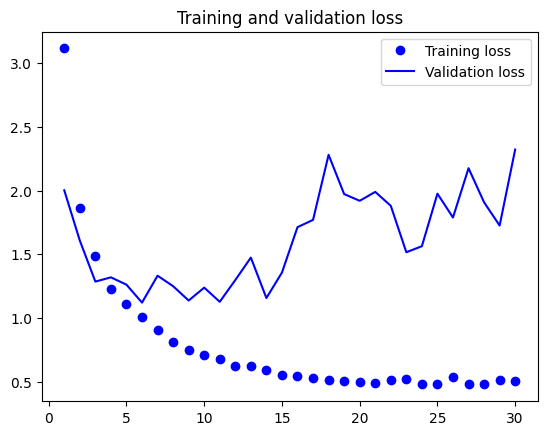

**val_acc:** 0.734000027179718

#### Conclusão

Como podemos concluir a partir dos gráficos apresentados, os valores de precisão da classificação do conjunto de dados de validação, com o uso de *transfer learning* melhoraram, em comparação aos modelos S, 16%. Porém aplicando a técnica de *fine tuning* piorou, e inclusive obteve menores valores de precisão da classificação do conjunto de dados de validação em comparação ao modelo S com *data augmentation*. É também claro pela observação dos gráficos, como consequência de não ser usado *data augmentation* que existe uma dispersão entre os valores de precisão do conjunto de dados de validação (val_accuracy), em relação aos valores de precisão do conjunto de dados de treino (accuracy).

**Nota:** Neste modelo não conseguimos aplicar o *feature extraction* em conjunto com o *fine tuning* porque ao juntar o modelo pré-treinado no modelo de classificação, ou seja, ao fazer o *full model* ficavamos com um nº de camadas muito reduzido para aplicar fine tuning. A nossa tentiva disso está num *notebook* na pasta notebooks descontinuados.